# QP constrained optimization: Normalizing Flow with projection constraints

* Objective: maximize absolute entropy.
* Constraint: match 1D projections onto $x$ and $y$.
* Exact solution: $p(x, y) = p(x)p(y)$.

In [1]:
import math
from typing import Callable

import cheetah
import matplotlib.pyplot as plt
import torch
import zuko
from tqdm.notebook import trange

## Ground truth distribution

In [2]:
def sample_true_dist(n: int) -> torch.Tensor:
    nrings = 2
    radii = torch.linspace(0.0, 1.0, nrings + 1)
    radii = radii[1:]

    n = n // nrings

    particles = []
    for r in radii:
        t = 2.0 * torch.pi * torch.rand((n,))
        x = r * torch.cos(t)
        y = r * torch.sin(t)
        particles.append(torch.stack([x, y], axis=-1))
    particles = torch.vstack(particles)

    
    particles = particles / torch.std(particles, axis=0)
    particles = particles + 0.15 * torch.randn(particles.shape)
    return particles

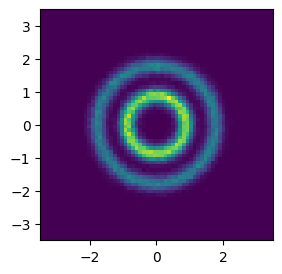

In [3]:
x_true = sample_true_dist(100_000)
plot_xmax = 3.5
plot_limits = 2 * [(-plot_xmax, plot_xmax)]

fig, ax = plt.subplots(figsize=(3, 3))
ax.hist2d(x_true[:, 0], x_true[:, 1], bins=64, range=plot_limits)
plt.show()

## Forward model

In [4]:
diag_edges = torch.linspace(-4.0, 4.0, 64)
diag_coords = 0.5 * (diag_edges[1:] + diag_edges[:-1])
diag_cell_volume = diag_coords[1] - diag_coords[0]
diag_bw = (diag_coords[1] - diag_coords[0]) * 0.5


def simulate(x: torch.Tensor) -> torch.Tensor:
    data = []
    for axis in range(x.shape[1]):
        values = cheetah.utils.kde.kde_histogram_1d(
            x[:, axis],
            bins=diag_coords,
            bandwidth=diag_bw,   
        )
        values = values / torch.sum(values) / diag_cell_volume
        data.append(values)
    return data

In [5]:
with torch.no_grad():
    data_true = simulate(x_true)

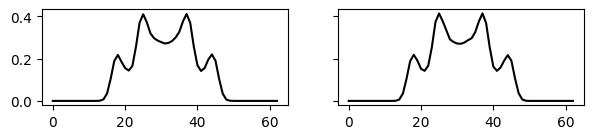

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(7.0, 1.25), sharex=True, sharey=True)
for ax, values in zip(axs, data_true):
    ax.plot(values, color="black")
plt.show()

## Reconstruction model

In [7]:
def constraint_function(x: torch.Tensor) -> torch.Tensor:
    data_pred = simulate(x)

    loss = 0.0
    for y_pred, y_true in zip(data_pred, data_true):
        loss = loss + torch.mean(torch.abs(y_pred - y_true))
    loss = loss / len(data_pred)
    return loss

In [8]:
class FlowDist(torch.nn.Module):
    def __init__(
        self,
        ndim: int,
        transforms: int = 3,
        hidden_layers: int = 3,
        hidden_units: int = 64,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.flow = zuko.flows.NSF(
            features=ndim,
            transforms=transforms,
            hidden_features=(hidden_layers * [hidden_units]),
        )
        # Reverse for faster sampling
        self.flow = zuko.flows.Flow(self.flow.transform.inv, self.flow.base)

    def sample(self, n: int) -> torch.Tensor:
        return self.flow().rsample((n,))

    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.flow().log_prob(z)

    def sample_and_log_prob(self, n: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.flow().rsample_and_log_prob((n,))
    
    def entropy(self, n: int, prior=None) -> torch.Tensor:
        x, log_p = self.sample_and_log_prob(n)
        if prior is None:
            log_q = torch.zeros(log_p.shape)
        else:
            log_q = prior.log_prob(x)
        return -torch.mean(log_p - log_q)

In [9]:
class Gaussian:
    def __init__(self, ndim: int, scale: torch.Tensor) -> None:
        self.ndim = ndim
        self.scale = scale

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        denom = math.sqrt((2.0 * math.pi) ** self.ndim) * torch.sqrt(torch.prod(self.scale))
        return -0.5 * torch.sum((x / self.scale)**2, axis=1) - denom

In [10]:
def estimate_entropy(x: torch.Tensor, log_prob: torch.Tensor, prior=None) -> torch.Tensor:
    if prior is None:
        log_prob_prior = torch.ones(log_prob.shape)
    else:
        log_prob_prior = prior.log_prob(x)
    return -torch.mean(log_prob - log_prob_prior)

In [11]:
class QPOptimizer:
    def __init__(
        self, 
        dist: FlowDist,
        optimizer: torch.optim.Optimizer, 
        constraint_function: Callable,
        c: float= 1.0,
        eps: float = 1.00e-12,
        batch_size: int = 10_000,
        prior=None,
    ) -> None:
        self.dist = dist
        self.prior = prior
        self.optimizer = optimizer
        self.constraint_function = constraint_function
        self.c = c
        self.eps = eps
        self.batch_size = batch_size        

    def step(self) -> dict:
        self.optimizer.zero_grad()
        
        # Sample particles coordinates and density at each point
        x, log_prob = self.dist.sample_and_log_prob(self.batch_size)

        # Compute objective function gradient
        f = -estimate_entropy(x, log_prob, prior=self.prior)
        f.backward(retain_graph=True)

        grads_f = []
        for p in self.dist.parameters():
            if p.grad is not None:
                grads_f.append(p.grad.clone())

        for p in self.dist.parameters():
            p.grad.zero_()

        # Compute constraint function gradient
        g = self.constraint_function(x)
        g.backward()

        grads_g = []
        for p in self.dist.parameters():
            if p.grad is not None:
                grads_g.append(p.grad.clone())

        # Step optimizer with mixed gradient
        with torch.no_grad():
            grad_f_vec = torch.hstack([grad.ravel() for grad in grads_f])
            grad_g_vec = torch.hstack([grad.ravel() for grad in grads_g])
            alpha = max(0.0, -torch.dot(grad_f_vec, grad_g_vec) + self.c * g) / max(torch.linalg.norm(grad_g_vec)**2, self.eps)
            
            for i, p in enumerate(self.dist.parameters()):
                p.grad = grads_f[i] + alpha * grads_g[i]

            self.optimizer.step()

        output = {}
        output["f"] = f.detach()
        output["g"] = g.detach()
        return output

In [12]:
ndim = 2
c = 10.0

dist = FlowDist(ndim=2, transforms=4, hidden_layers=3, hidden_units=64)
prior = Gaussian(ndim=2, scale=torch.ones(ndim))
optimizer = torch.optim.Adam(dist.parameters(), lr=0.01)

qp_optimizer = QPOptimizer(
    dist=dist,
    prior=prior,
    optimizer=optimizer,
    constraint_function=constraint_function,
    c=c,
    batch_size=30_000,
)

for iteration in trange(50):
    optimizer.zero_grad()
    loss = -dist.entropy(1000)
    loss.backward()
    optimizer.step()

history = {"f": [], "g": []}
for iteration in trange(300):
    output = qp_optimizer.step()

    history["f"].append(output["f"])
    history["g"].append(output["g"])

    if iteration > 100:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
            param_group["lr"] = max(param_group["lr"], 0.001)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

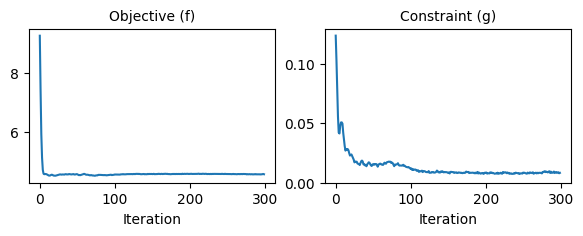

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(7.0, 2.0), sharex=True)
axs[0].plot(history["f"])
axs[1].plot(history["g"])
axs[1].set_ylim(0.0, axs[1].get_ylim()[1])
axs[0].set_title("Objective (f)", fontsize="medium")
axs[1].set_title("Constraint (g)", fontsize="medium")
for ax in axs:
    ax.set_xlabel("Iteration")
plt.show()

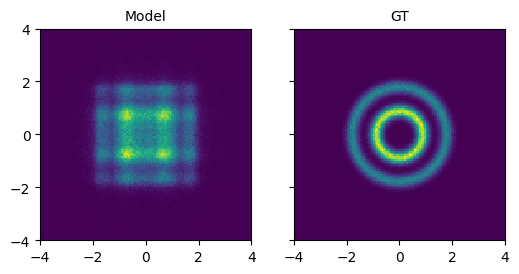

In [14]:
with torch.no_grad():
    x_pred = dist.sample(500_000)
    x_true = sample_true_dist(x_pred.shape[0])
    fig, axs = plt.subplots(figsize=(6.0, 2.75), ncols=2, sharex=True, sharey=True)
    xmax = 4.0
    for x, ax in zip([x_pred, x_true], axs):
        ax.hist2d(x[:, 0], x[:, 1], bins=128, range=[(-xmax, xmax), (-xmax, xmax)])
    axs[0].set_title("Model", fontsize="medium")
    axs[1].set_title("GT", fontsize="medium")
    plt.show()

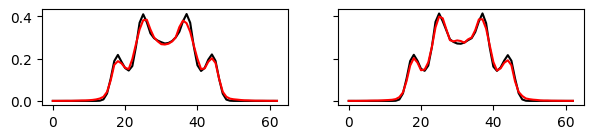

In [15]:
with torch.no_grad():
    x_pred = dist.sample(100_000)
    data_pred = simulate(x_pred)
        
    fig, axs = plt.subplots(ncols=2, figsize=(7.0, 1.25), sharex=True, sharey=True)
    for ax, y_true, y_pred in zip(axs, data_true, data_pred):
        ax.plot(y_true, color="black")
        ax.plot(y_pred, color="red")
    plt.show()
